In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/schubert'

schu_143_1.mid	  schub_d960_2.mid     schubert_D935_2.mid  schumm-2.mid
schu_143_2.mid	  schub_d960_3.mid     schubert_D935_3.mid  schumm-3.mid
schu_143_3.mid	  schub_d960_4.mid     schubert_D935_4.mid  schumm-4.mid
schub_d760_1.mid  schubert_D850_1.mid  schuim-1.mid	    schumm-5.mid
schub_d760_2.mid  schubert_D850_2.mid  schuim-2.mid	    schumm-6.mid
schub_d760_3.mid  schubert_D850_3.mid  schuim-3.mid
schub_d760_4.mid  schubert_D850_4.mid  schuim-4.mid
schub_d960_1.mid  schubert_D935_1.mid  schumm-1.mid


# **WaveNet**
![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/12/arcg.jpg)

**The Workflow of WaveNet:**


*   Input is fed into a causal 1D convolution
*   The output is then fed to 2 different dilated 1D convolution layers with sigmoid and tanh activations
*   The element-wise multiplication of 2 different activation values results in a skip connection
*   And the element-wise addition of a skip connection and output of causal 1D results in the residual



In [0]:
# music 21 library
from music21 import *

In [0]:
# reading midi file 
def read_midi(file):
  print("Loading music file",file)
  notes=[]
  notes_to_parse=None
  midi = converter.parse(file)
  s2 = instrument.partitionByInstrument(midi)
  for part in s2.parts:
    if 'Piano' in str(part):
      notes_to_parse = part.recurse()
      for element in notes_to_parse:
        if isinstance(element, note.Note):
          notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
          notes.append('.'.join(str(n) for n in element.normalOrder))
  
  return np.array(notes)


In [6]:
import os
import numpy as np
path='/content/drive/My Drive/schubert/'

files=[i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi(path+i) for i in files])


Loading music file /content/drive/My Drive/schubert/schubert_D850_1.mid
Loading music file /content/drive/My Drive/schubert/schubert_D850_2.mid
Loading music file /content/drive/My Drive/schubert/schubert_D850_3.mid
Loading music file /content/drive/My Drive/schubert/schubert_D850_4.mid
Loading music file /content/drive/My Drive/schubert/schub_d760_1.mid
Loading music file /content/drive/My Drive/schubert/schub_d760_2.mid
Loading music file /content/drive/My Drive/schubert/schub_d760_3.mid
Loading music file /content/drive/My Drive/schubert/schub_d760_4.mid
Loading music file /content/drive/My Drive/schubert/schumm-1.mid
Loading music file /content/drive/My Drive/schubert/schumm-2.mid
Loading music file /content/drive/My Drive/schubert/schumm-3.mid
Loading music file /content/drive/My Drive/schubert/schumm-4.mid
Loading music file /content/drive/My Drive/schubert/schumm-5.mid
Loading music file /content/drive/My Drive/schubert/schumm-6.mid
Loading music file /content/drive/My Drive/sch

In [7]:
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))


304


(array([187.,  41.,  26.,  11.,   6.,   9.,  12.,   6.,   3.,   3.]),
 array([1.0000e+00, 1.4790e+02, 2.9480e+02, 4.4170e+02, 5.8860e+02,
        7.3550e+02, 8.8240e+02, 1.0293e+03, 1.1762e+03, 1.3231e+03,
        1.4700e+03]),
 <a list of 10 Patch objects>)

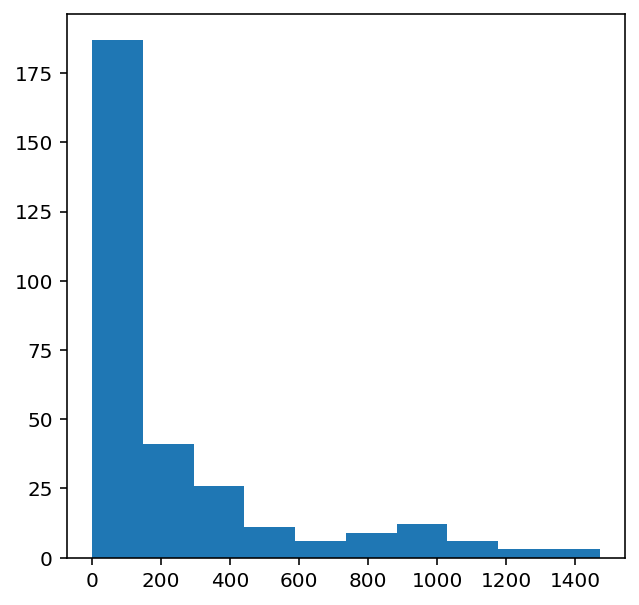

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

freq = dict(Counter(notes_))
no=[count for _,count in freq.items()]

plt.figure(figsize=(5,5))
plt.hist(no)

In [9]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

167


In [0]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

# **Preprocessing data**

In [12]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)
y

array(['G4', 'G3', 'F#4', ..., 'B-1', 'G#1', 'G1'], dtype='<U8')

In [14]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))
print(x_note_to_int)

{'2': 0, 'E5': 1, 'B-4': 2, '0.3': 3, 'A6': 4, '8.0': 5, '7.10.0': 6, 'A2': 7, 'B4': 8, 'G#5': 9, '1': 10, '7.10.2': 11, '3.8': 12, '6.8': 13, 'D5': 14, '8.11': 15, '10.1': 16, 'D3': 17, '4': 18, '6.9.1': 19, 'E6': 20, 'C7': 21, 'G6': 22, 'F6': 23, 'G5': 24, '0.4': 25, '4.7.11': 26, '4.7.9': 27, '7.11.2': 28, 'C#7': 29, '7.10.1': 30, '0.3.5': 31, '3.9': 32, 'D4': 33, '1.4.8': 34, 'D2': 35, 'E-2': 36, 'B-2': 37, '1.4.7': 38, '7.11': 39, '8.11.3': 40, '5.9.0': 41, '8.1': 42, 'C4': 43, '9.1.4': 44, 'C3': 45, 'A3': 46, '10.3': 47, 'C#2': 48, 'E-6': 49, '6': 50, '4.8.11': 51, '3': 52, '10.1.3': 53, '11.2': 54, 'C6': 55, '2.8': 56, '1.7': 57, '2.7': 58, '3.6.8': 59, '2.5.7': 60, '10.2': 61, '11.3': 62, 'B-3': 63, 'B3': 64, '2.5': 65, 'A1': 66, '0.2.6': 67, '5.10': 68, 'G#3': 69, '2.6': 70, '0.3.6': 71, '6.10': 72, '5.8.11': 73, '11': 74, '10.1.5': 75, 'E-4': 76, 'E4': 77, 'B2': 78, '4.10': 79, 'E-5': 80, '0.4.7': 81, '9': 82, '8.0.3': 83, 'C#4': 84, '2.4.8': 85, 'F#2': 86, 'C#6': 87, '11.2.6

In [16]:
x_seq=[]
for i in x:
  temp=[]
  for j in i:
      #assigning unique integer to every note
    temp.append(x_note_to_int[j])
  x_seq.append(temp)
    
x_seq = np.array(x_seq)
x_seq

array([[ 92,   0, 123, ...,  39,  77, 119],
       [  0, 123,  70, ...,  77, 119, 101],
       [123,  70, 123, ..., 119, 101, 129],
       ...,
       [ 23,  49,  87, ...,  36,  48, 148],
       [ 49,  87,  55, ...,  48, 148, 161],
       [ 87,  55, 102, ..., 148, 161, 100]])

In [18]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])
y_seq

array([101, 129, 131, ..., 161, 100,  94])

In [0]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

**Model building**

In [0]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

  

In [21]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           16700     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 128)           

In [0]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [0]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 51530 samples, validate on 12883 samples
Epoch 1/50
51530/51530 [==============================] - 33s 642us/step - loss: 4.3318 - val_loss: 4.0082

Epoch 00001: val_loss improved from inf to 4.00821, saving model to best_model.h5
Epoch 2/50
51530/51530 [==============================] - 32s 627us/step - loss: 3.7683 - val_loss: 3.8066

Epoch 00002: val_loss improved from 4.00821 to 3.80659, saving model to best_model.h5
Epoch 3/50
51530/51530 [==============================] - 32s 629us/step - loss: 3.5833 - val_loss: 3.6389

Epoch 00003: val_loss improved from 3.80659 to 3.63894, saving model to best_model.h5
Epoch 4/50
51530/51530 [==============================] - 33s 632us/step - loss: 3.4540 - val_loss: 3.5618

Epoch 00004: val_loss improved from 3.63894 to 3.56182, saving model to best_model.h5
Epoch 5/50
51530/51530 [==============================] - 32s 629us/step - loss: 3.3543 - val_loss: 3.4680

Epoch 00005: val_loss improved from 3.56182 to 3.46796, saving model t

In [0]:
from keras.models import load_model
model = load_model('best_model.h5')